In [2]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from random import sample
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split


def get_insurance_data():
	insurance = pd.read_csv('insurance.csv')
	insurance['sex'] = insurance['sex'].map({'male': 1, 'female': 0})
	insurance['smoker'] = insurance['smoker'].map({'yes': 1, 'no': 0})
	insurance['region'] = insurance['region'].map({'northeast': 3, 'northwest': 2, 'southeast': 1, 'southwest': 0})
	cols_to_norm = ['charges','age','bmi']
	insurance[cols_to_norm] = insurance[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

	male_indices = insurance[insurance['sex'] == 1].index.tolist()
	number_male_indices = int(len(male_indices)*50/100)
	female_indices = insurance[insurance['sex'] == 0].index.tolist()
	number_female_indices = int(len(female_indices)*100/100)
	insurance = insurance.loc[sample(male_indices,number_male_indices) + sample(female_indices,number_female_indices)]

	E = insurance['sex'] 
	y = insurance['charges']
	insurance = insurance.drop(['sex','charges'], axis=1)
	train_features, test_features, E_train, E_test, y_train, y_test = train_test_split(insurance, E, y, test_size=0.2, random_state = 0)
	return train_features, test_features, E_train, E_test, y_train, y_test


def get_data_loaded(train_features, y_train, E_train):
  train_tensor = data_utils.TensorDataset(torch.Tensor(train_features.values), torch.Tensor(y_train.values).flatten(), torch.Tensor(E_train.values))
  train_loader = data_utils.DataLoader(train_tensor, batch_size=50, shuffle=True)
  return train_tensor, train_loader
  

def get_mse_coverage(mse_df):
	mse_cov = []
	cov = []
	samples_cov = []
	for count, datapoint in enumerate(mse_df.index):
		samples_cov.append(datapoint)
		mse_cov.append(np.sum(mse_df['mse'][samples_cov])/len(samples_cov))
		cov.append((count+1)/mse_df.shape[0])

	mse_cov_new = []
	cov_new = []
	for i in range(len(cov)):
		if cov[i] > 0.1:
			cov_new.append(cov[i])
			mse_cov_new.append(mse_cov[i])

	return mse_cov_new, cov_new


def AUC(x,y):
	area = 0
	for i in range(len(x)-1):
		area += np.abs((x[i+1]-x[i]))*y[i]
	return area

In [3]:
class Featurizer(nn.Module):
  def __init__(self, input_size, hiden_size=5):
    super(Featurizer, self).__init__()
    self.first = nn.Linear(input_size, hiden_size)
  

  def forward(self, x):
    out = F.selu(self.first(x))
    return out


class RegressorGroup(nn.Module):
  def __init__(self, output_size, hiden_size, num_domains, activation = False):
    super(RegressorGroup, self).__init__()
    self.last = []
    self.activation = activation
    for i in range(num_domains):
      self.last.append(nn.Linear(hiden_size, output_size))

    self.last = nn.ModuleList(self.last)
  
  
  def forward(self, x, d):
    if self.activation:
      out = F.softplus(self.last[d](x))
    else:
      out = self.last[d](x)
    return out


class RegressorJoint(nn.Module):
  def __init__(self, output_size, hiden_size, activation = False):
    super(RegressorJoint, self).__init__()
    self.last = nn.Linear(hiden_size, output_size)
    self.activation = activation
    
    
  def forward(self, x):
    if self.activation:
      out = F.softplus(self.last(x))
    else:
      out = self.last(x)
    return out

In [4]:
from scipy.stats import gaussian_kde
import torch

def partition(list_in, num_domains):
    np.random.shuffle(list_in)
    return [list_in[i::num_domains] for i in range(num_domains)]

# def chi_squared_loss(observed, expected):
#     """Calculate the chi-squared loss."""
#     # Ensure expected is not zero to avoid division by zero
#     expected = torch.clamp(expected, min=1e-8)
#     return torch.sum((observed - expected) ** 2 / expected)

# def calculate_lindep(features, e):
#     """Compute L_indep as chi-squared loss between observed and expected counts."""
#     num_domains = 2  # Adjust according to your use case

#     # Initialize observed counts
#     observed_counts = torch.zeros(num_domains)

#     for e_dummy in range(num_domains):
#         # Select the features for the current domain
#         features_domain = features[e == e_dummy, :]
#         print(features_domain,"Hi")
#         # Here you might use a transformation or aggregation to get observed counts
#         observed_counts[e_dummy] = torch.mean(features_domain, dim=0).sum()  # Example

#     # Expected counts can be determined based on prior knowledge or distributions
#     expected_counts = torch.ones(num_domains) * (features.size(0) / num_domains)  # Simplified assumption

#     # Calculate chi-squared loss
#     return chi_squared_loss(observed_counts, expected_counts)



def chi_squared_loss(observed, expected):
    """Calculate the chi-squared loss."""
    # Ensure expected is not zero to avoid division by zero
    expected = torch.clamp(expected, min=1e-8)
    return torch.sum((observed - expected) ** 2 / expected)


def calculate_lindep(features, e):
    """Compute L_indep as chi-squared loss between observed and expected counts, using KDE."""
    num_domains = 2  # Adjust according to your use case

    observed_counts = torch.zeros(num_domains)

    for e_dummy in range(num_domains):
        # Select features for the current domain
        features_domain = features[e == e_dummy, :]

        # Flatten features if needed (KDE expects a 1D or 2D input, so reshape if necessary)
        features_domain_flat = features_domain.detach().cpu().numpy().reshape(-1)



        # Apply KDE to estimate density
        kde = gaussian_kde(features_domain_flat)
        
        # Integrate the KDE over the feature range to get an "observed count" approximation
        observed_counts[e_dummy] = torch.tensor(kde.integrate_box_1d(features_domain_flat.min(), features_domain_flat.max()) * len(features_domain_flat))

    # Expected counts can be based on an even distribution across domains or a prior distribution
    expected_counts = torch.ones(num_domains) * (features.size(0) / num_domains)
    

    # Calculate chi-squared loss
    return chi_squared_loss(expected_counts,observed_counts)


def sufficiency(train_tensor, train_loader, args):
    training_loss = []
    input_size = train_tensor.tensors[0].size(1)
    output_size = 1
    num_domains = 2

    learning_rate = args['learning_rate']
    hidden_size = args['hidden_size']
    num_epochs = args['num_epochs']
    batch_size = args['batch_size']
    lbda = args['lbda']
    lbda1 = args['lbda1']
    activation = args['activation']

    featurizer = Featurizer(input_size, hidden_size)
    regressorJoint = RegressorJoint(output_size, hidden_size, activation)
    regressorGroup = RegressorGroup(output_size, hidden_size, num_domains, activation)
    modelJoint = nn.Sequential(featurizer, regressorJoint)
    modelGroup = nn.Sequential(featurizer, regressorGroup)

    criterion = nn.MSELoss()
    optimizer_featurizer = torch.optim.Adam(featurizer.parameters(), lr=learning_rate, weight_decay=0)
    scheduler_featurizer = torch.optim.lr_scheduler.StepLR(optimizer_featurizer, step_size=2, gamma=0.5)
    optimizer_r_joint = torch.optim.Adam(regressorJoint.parameters(), lr=learning_rate, weight_decay=0)
    scheduler_r_joint = torch.optim.lr_scheduler.StepLR(optimizer_r_joint, step_size=2, gamma=0.5)
    optimizer_r_group = torch.optim.Adam(regressorGroup.parameters(), lr=learning_rate, weight_decay=0)
    scheduler_r_group = torch.optim.lr_scheduler.StepLR(optimizer_r_group, step_size=2, gamma=0.5)

    for epoch in range(num_epochs):
        t_loss = 0
        for i, (x, y, e) in enumerate(train_loader):
           
            y = y.reshape(-1, 1)
            features = featurizer(x)
            y_hat_joint = regressorJoint(features)
            
            joint_loss = criterion(y_hat_joint.reshape(-1, 1), y.reshape(-1, 1))
            # Flatten features and calculate mutual information
            # Compute group-specific loss
            group_specific_loss = 0
            for e_dummy in range(num_domains):
                y_domain = y[e == e_dummy]
                features_domain = features[e == e_dummy, :]
                y_hat_domain = regressorGroup(features_domain, e_dummy)
                group_specific_loss += criterion(y_hat_domain.reshape(-1, 1), y_domain.reshape(-1, 1))

            # Compute group-agnostic loss
            indices = partition(np.arange(x.size(0)), num_domains)
            group_agnostic_loss = 0
            for e_dummy in range(num_domains):
                y_domain = y[indices[e_dummy]]
                features_domain = features[indices[e_dummy], :]
                y_hat_domain = regressorGroup(features_domain, e_dummy)
                group_agnostic_loss += criterion(y_hat_domain.reshape(-1, 1), y_domain.reshape(-1, 1))

            # Calculate L_indep using the observed and expected counts
            lindep_loss = calculate_lindep(features, e)

            # Total loss with subgroup selective risk
            loss = joint_loss - lbda * (group_specific_loss - group_agnostic_loss) + lbda1 * lindep_loss

            optimizer_featurizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_featurizer.step()

            optimizer_r_joint.zero_grad()
            loss.backward(retain_graph=True)
            optimizer_r_joint.step()

            optimizer_r_group.zero_grad()
            group_specific_loss.backward(retain_graph=True)
            optimizer_r_group.step()

            t_loss += loss.item()  # Accumulate the total loss correctly

        scheduler_featurizer.step()
        scheduler_r_joint.step()
        scheduler_r_group.step()
        training_loss.append(t_loss / (i + 1))

    return modelJoint, training_loss

In [5]:
def train_mean_network(train_features, E_train, y_train, args):
    train_tensor_mean, train_loader_mean = get_data_loaded(train_features, y_train, E_train)
    args['activation'] = False
    model_joint_mean, training_loss_mean = sufficiency(train_tensor_mean, train_loader_mean, args)
    return model_joint_mean, training_loss_mean


def train_var_network(train_features, E_train, y_train, args, model_joint_mean):
    train_tensor_mean, train_loader_mean = get_data_loaded(train_features, y_train, E_train)
    train_predicted_means = model_joint_mean(train_tensor_mean.tensors[0])
    y_train_var = torch.square(train_tensor_mean.tensors[1] - torch.squeeze(train_predicted_means))
    train_tensor_var, train_loader_var = get_data_loaded(pd.DataFrame(train_tensor_mean.tensors[0].detach().numpy()), pd.Series(y_train_var.detach().numpy()), pd.Series(train_tensor_mean.tensors[2].detach().numpy()))
    args['activation'] = True
    model_joint_var, training_loss_var = sufficiency(train_tensor_var, train_loader_var, args)
    
    return model_joint_var, training_loss_var


def test_network(test_features, E_test, y_test, model_joint_var, model_joint_mean):
    test_tensor_mean = data_utils.TensorDataset(torch.Tensor(test_features.values), torch.Tensor(y_test.values).flatten(), torch.Tensor(E_test.values))
    test_predicted_means = model_joint_mean(test_tensor_mean.tensors[0])
    y_test_var = torch.square(test_tensor_mean.tensors[1] - torch.squeeze(test_predicted_means))
    test_tensor_var = data_utils.TensorDataset(test_tensor_mean.tensors[0], torch.Tensor(pd.Series(y_test_var.detach().numpy()).values), test_tensor_mean.tensors[2])
    test_predicted_var = model_joint_var(test_tensor_var.tensors[0])

    mse = pd.DataFrame(y_test_var.detach().numpy(), columns=['mse'])
    mse['variance'] = torch.squeeze(test_predicted_var).detach().numpy()
    mse['e'] = E_test.to_numpy().reshape(-1,1)
    mse = mse.sort_values(['variance'], ascending=[True])
    return mse

In [6]:
train_features, test_features, E_train, E_test, y_train, y_test = get_insurance_data()

In [7]:
args_baseline = {'num_epochs':40,'batch_size':128,'learning_rate':5e-3,'hidden_size':3,'lbda':0.0,'lbda1':0.0}
residue_baseline_model_mean, _ = train_mean_network(train_features, E_train, y_train, args_baseline)
residue_baseline_model_var, _ = train_var_network(train_features, E_train, y_train, args_baseline, residue_baseline_model_mean)

residue_baseline_mse_df = test_network(test_features, E_test, y_test, residue_baseline_model_var, residue_baseline_model_mean)
residue_baseline_mse, residue_baseline_cov = get_mse_coverage(residue_baseline_mse_df)
residue_baseline_mse_0, residue_baseline_cov_0 = get_mse_coverage(residue_baseline_mse_df[residue_baseline_mse_df['e']==0])
residue_baseline_mse_1, residue_baseline_cov_1 = get_mse_coverage(residue_baseline_mse_df[residue_baseline_mse_df['e']==1])

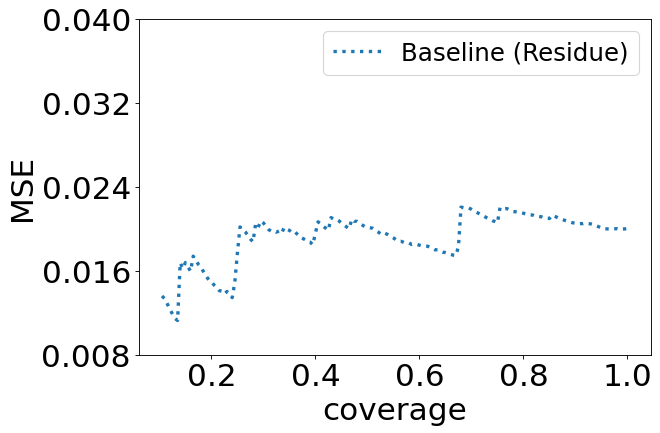

In [8]:
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.18, .2, .80, .70))

line1 = plt.plot(residue_baseline_cov, residue_baseline_mse, ':', linewidth = 3.0, label = 'Baseline (Residue)')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize = 28)
ax.set_ylabel("MSE",fontsize = 28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.008,0.016,0.024,0.032,0.040], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', fontsize=22)

plt.show()

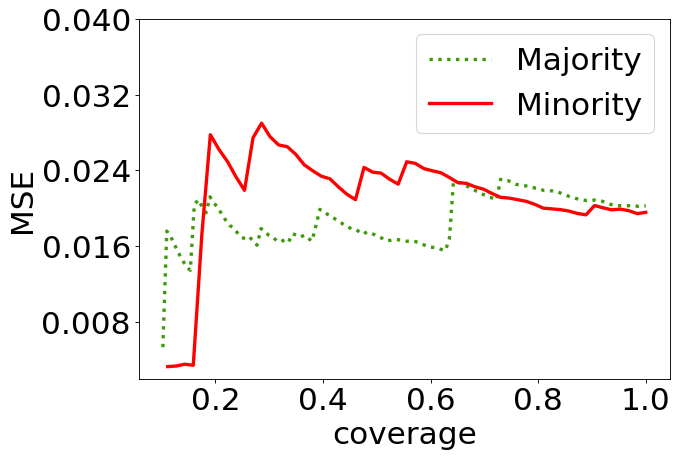

In [9]:
# Gaussian (one-stage) baseline
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.165, .2, .83, .75))

line1 = plt.plot(residue_baseline_cov_0, residue_baseline_mse_0, ':', linewidth = 3.0, label = 'Majority', color = '#3E9A0A')
line2 = plt.plot(residue_baseline_cov_1, residue_baseline_mse_1, linewidth = 3.0, label = 'Minority', color = '#FF0000')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize =28)
ax.set_ylabel("MSE",fontsize =28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.008,0.016,0.024,0.032,0.040], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', fontsize=28)

plt.show()

In [10]:
args_calibration = {'num_epochs':40,'batch_size':128,'learning_rate':5e-3,'hidden_size':3,'lbda':1.0,'lbda1':0.0}
residue_calibration_model_mean, _ = train_mean_network(train_features, E_train, y_train, args_calibration)
residue_calibration_model_var, _ = train_var_network(train_features, E_train, y_train, args_calibration, residue_calibration_model_mean)

residue_calibration_mse_df = test_network(test_features, E_test, y_test, residue_calibration_model_var, residue_calibration_model_mean)
residue_calibration_mse, residue_calibration_cov = get_mse_coverage(residue_calibration_mse_df)
residue_calibration_mse_0, residue_calibration_cov_0 = get_mse_coverage(residue_calibration_mse_df[residue_calibration_mse_df['e']==0])
residue_calibration_mse_1, residue_calibration_cov_1 = get_mse_coverage(residue_calibration_mse_df[residue_calibration_mse_df['e']==1])

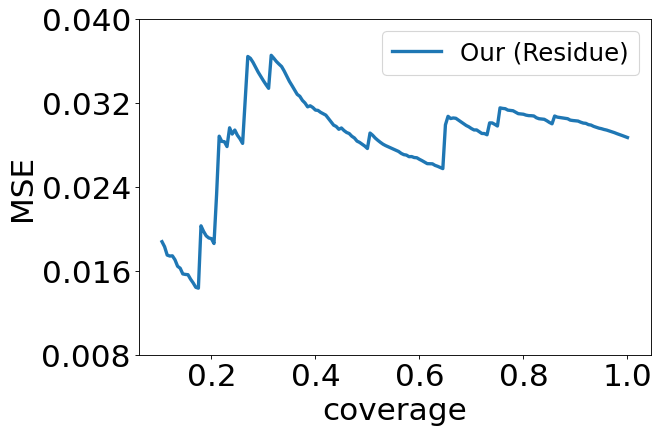

In [11]:
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.18, .2, .80, .70))

line1 = plt.plot(residue_calibration_cov, residue_calibration_mse, linewidth = 3.0, label = 'Our (Residue)')	

ax = plt.gca()
ax.set_xlabel("coverage",fontsize = 28)
ax.set_ylabel("MSE",fontsize = 28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.008,0.016,0.024,0.032,0.040], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', fontsize=22)

plt.show()

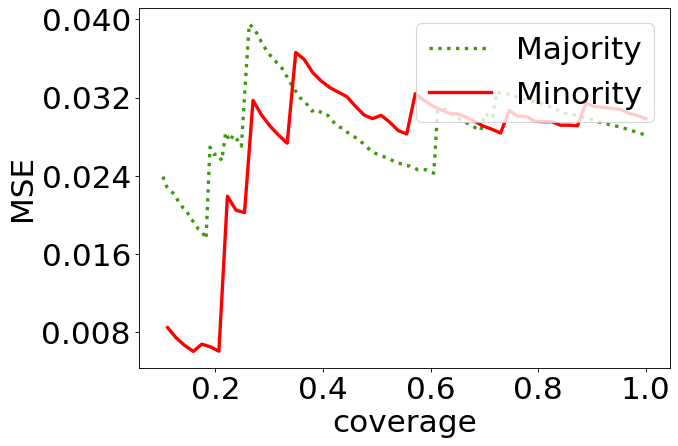

In [12]:
# Gaussian (one-stage) sufficiency
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.165, .2, .83, .75))

line1 = plt.plot(residue_calibration_cov_0, residue_calibration_mse_0, ':', linewidth = 3.0, label = 'Majority', color = '#3E9A0A')
line2 = plt.plot(residue_calibration_cov_1, residue_calibration_mse_1, linewidth = 3.0, label = 'Minority', color = '#FF0000')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize =28)
ax.set_ylabel("MSE",fontsize =28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.008,0.016,0.024,0.032,0.040], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', fontsize=28)

plt.show()

In [13]:
args_calibration = {'num_epochs':40,'batch_size':128,'learning_rate':5e-3,'hidden_size':3,'lbda':0.5,'lbda1':1.0}
residue_calibration_model_mean, _ = train_mean_network(train_features, E_train, y_train, args_calibration)
residue_calibration_model_var, _ = train_var_network(train_features, E_train, y_train, args_calibration, residue_calibration_model_mean)

residue_calibration_mse_df = test_network(test_features, E_test, y_test, residue_calibration_model_var, residue_calibration_model_mean)
residue_calibration_mse, residue_calibration_cov = get_mse_coverage(residue_calibration_mse_df)
residue_calibration_mse_0, residue_calibration_cov_0 = get_mse_coverage(residue_calibration_mse_df[residue_calibration_mse_df['e']==0])
residue_calibration_mse_1, residue_calibration_cov_1 = get_mse_coverage(residue_calibration_mse_df[residue_calibration_mse_df['e']==1])

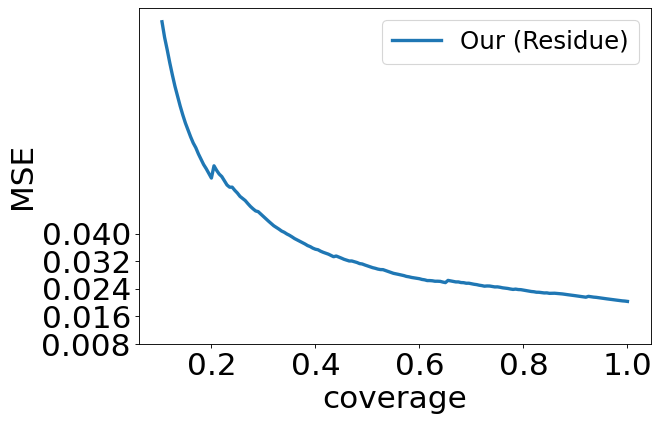

In [14]:
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.18, .2, .80, .70))

line1 = plt.plot(residue_calibration_cov, residue_calibration_mse, linewidth = 3.0, label = 'Our (Residue)')	

ax = plt.gca()
ax.set_xlabel("coverage",fontsize = 28)
ax.set_ylabel("MSE",fontsize = 28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.008,0.016,0.024,0.032,0.040], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', fontsize=22)

plt.show()

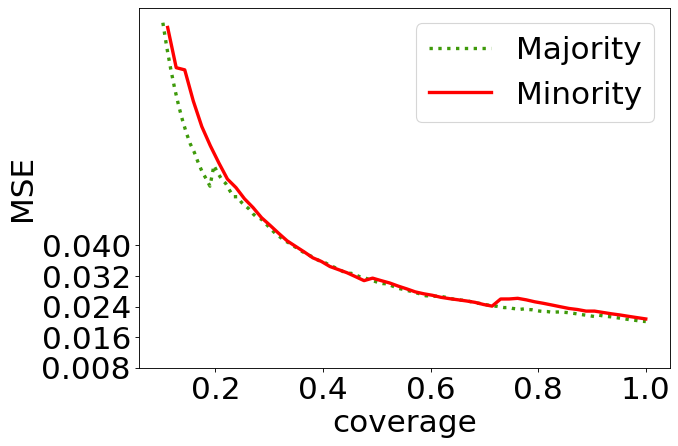

In [15]:
# Gaussian (one-stage) sufficiency
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.165, .2, .83, .75))

line1 = plt.plot(residue_calibration_cov_0, residue_calibration_mse_0, ':', linewidth = 3.0, label = 'Majority', color = '#3E9A0A')
line2 = plt.plot(residue_calibration_cov_1, residue_calibration_mse_1, linewidth = 3.0, label = 'Minority', color = '#FF0000')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize =28)
ax.set_ylabel("MSE",fontsize =28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.008,0.016,0.024,0.032,0.040], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper right', fontsize=28)

plt.show()